# 对编解码器的注意力机制的思考

在之前实现的的注意力机制编解码器模型中，编码器的隐藏状态既参与了对齐分数`scores`的计算，又参与生成背景向量，这样分身两地的安排对编码器的隐藏状态要求可能不一致，从而影响模型效果。

其次，注意力机制实现的其实是更好的隐藏状态的功能，是否可以将注意力机制单拎出来成为一个独立的模型组件，甚至可以直接使用注意力从而不需要计算`hidden`？

Atttion Is All You Need！当然！我们可以惊喜的告诉你：隐藏状态，不需要了（）

你只需要注意力。并且由于不需要计算隐藏状态，循环神经网络固有的串行限制也不存在了。并且这样反而效果更好。

# 单向自注意力

在 Transformer 的自注意力机制（Self-Attention）中，Q (Query)、K (Key)、V (Value) 是最核心的三个概念，它们共同决定了输入序列中不同位置之间的交互方式。

1. Query (Q) 表示当前需要关注的内容（如当前输入）。

2. Key (K) 提供“索引”，用于匹配 Query。

3.  Value (V) 存储实际的信息，用于最终组合。


接下来我们会关注单向自注意力模型，也就是K,V来自于同一文本，并实现一个简单的单向自注意力模型。

*假设 K: (B, T, H)，Q: (B, T, H) 对齐分数则是 K @ Q.transpose(-2, -1): (B, T, T)*

*由于单向注意力不会注意到当前位置之后的 K ，对齐分数会使用下三角矩阵处理，如下*


In [1]:
import torch

scores = torch.randn(2, 4, 4)

print(scores)

tensor([[[-0.0621,  0.5833, -0.6850, -0.8048],
         [-2.1541,  0.1279, -1.2156,  1.1680],
         [-2.7450,  1.0879,  0.7630,  0.4266],
         [-1.1541,  0.2682,  1.8400, -1.0596]],

        [[ 1.0699, -0.2132, -0.1766,  1.2614],
         [ 0.2500, -2.2206, -0.8789, -1.4173],
         [ 1.3384,  0.9050,  0.6644, -1.3575],
         [ 1.3600,  0.1666, -0.5324, -0.1292]]])


In [2]:
# 定义下三角矩阵，使用 -inf 方便 softmax 归一化
tril = torch.tril(torch.ones(4, 4))
scores = scores.masked_fill(tril == 0, float('-inf'))
print(scores)

tensor([[[-0.0621,    -inf,    -inf,    -inf],
         [-2.1541,  0.1279,    -inf,    -inf],
         [-2.7450,  1.0879,  0.7630,    -inf],
         [-1.1541,  0.2682,  1.8400, -1.0596]],

        [[ 1.0699,    -inf,    -inf,    -inf],
         [ 0.2500, -2.2206,    -inf,    -inf],
         [ 1.3384,  0.9050,  0.6644,    -inf],
         [ 1.3600,  0.1666, -0.5324, -0.1292]]])


In [3]:
scores = torch.softmax(scores, dim=-1)
print(scores)

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.0926, 0.9074, 0.0000, 0.0000],
         [0.0124, 0.5733, 0.4143, 0.0000],
         [0.0382, 0.1582, 0.7617, 0.0419]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.9221, 0.0779, 0.0000, 0.0000],
         [0.4634, 0.3004, 0.2362, 0.0000],
         [0.5954, 0.1805, 0.0897, 0.1343]]])


In [4]:
# softmax对方差的敏感性
x = torch.randn(1, 8)
print(x.std())
print(torch.softmax(x, dim=-1))
print(torch.softmax(1000 * x, dim=-1))

tensor(1.2115)
tensor([[0.3281, 0.1276, 0.0245, 0.1377, 0.2910, 0.0564, 0.0171, 0.0176]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0.]])


In [5]:
# 在实际使用时的归一化还要控制方差以保留细节，处理方式是对齐分数 / H**0.5
B, T, H =32, 100, 10
K = torch.randn(B, T, H)
Q = torch.randn(B, T, H)
scores = K @ Q.transpose(-2, -1)
print(scores.std())
scores = scores / H**0.5
print(scores.std())

tensor(3.1778)
tensor(1.0049)


In [6]:
def attention(query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor):
    B, T, H = query.shape
    scores = query @ key.transpose(-2, -1) / H**0.5
    scores = scores.masked_fill(mask[:T, :T] == 0, float("-inf"))
    w_att = torch.softmax(scores, dim=-1)
    return w_att @ value


class SelfAttention(torch.nn.Module):
    def __init__(self, emb_size: int, head_size: int):
        # emb_size: C, head_size: H
        super().__init__()
        self.key = torch.nn.Linear(emb_size, head_size, bias=False)
        self.query = torch.nn.Linear(emb_size, head_size, bias=False)
        self.value = torch.nn.Linear(emb_size, head_size, bias=False)

    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        return attention(q, k, v, mask)


model = SelfAttention(3, 4)
x = torch.randn(5, 10, 3)
print(model(x, torch.tril(torch.ones(100, 100))).shape)

torch.Size([5, 10, 4])


# GPT 的 Transformer 模型架构

Transformer模型架构最初是为了改进机器翻译任务而设计的，通常被设计为编解码器模型。一般是交叉注意力的编码器和单向注意力的解码器。

由于GPT的任务是自回归生成而非序列到序列建模，于是仅使用了Transformer的解码器部分，完全删除了编码器部分

此外，GPT模型针对自回归生成任务调整了层归一化，残差连接等工程方法。我们在下面会一并实现。

# 多头注意力

由于注意力模块的输入是emb_size,输出是head_size,大小并不相同。而残差连接等方法要求每一层的张量大小相同。

于是在实现中考虑到emb_size一般比head_size大，使用多头注意力即把多个注意力进行简单的拼接使 n * head_size = emb_size，即可进行残差连接。

这里要求 emb_size 是 head_size 的整数倍

In [7]:
class SelfMultiHeadAttention(torch.nn.Module):
    def __init__(self, emb_size: int, head_size: int):
        assert emb_size % head_size == 0
        super().__init__()
        # 计算单头注意力的个数
        n_head = emb_size // head_size
        self.heads = torch.nn.ModuleList(SelfAttention(emb_size, head_size) for _ in range(n_head))
        self.proj = torch.nn.Linear(emb_size, emb_size)
        self.dp = torch.nn.Dropout(0.4)

    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        out = torch.cat([h(x, mask) for h in self.heads], dim=-1)
        out = self.dp(self.proj(out))
        return out

In [8]:
class FeedForward(torch.nn.Module):

    def __init__(self, emb_size: int):
        super().__init__()
        self.ln1 = torch.nn.Linear(emb_size, 4 * emb_size)
        self.ln2 = torch.nn.Linear(4 * emb_size, emb_size)
        self.dp = torch.nn.Dropout(0.4)

    def forward(self, x: torch.Tensor):
        out = torch.nn.functional.gelu(self.ln1(x))
        out = self.dp(self.ln2(out))
        return out

In [9]:
class Block(torch.nn.Module):
    def __init__(self, emb_size: int, head_size: int):
        super().__init__()
        self.layer_norm1 = torch.nn.LayerNorm(emb_size)
        self.mha = SelfMultiHeadAttention(emb_size, head_size)
        self.layer_norm2 = torch.nn.LayerNorm(emb_size)
        self.ff = FeedForward(emb_size)

    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        x = x + self.mha(self.layer_norm1(x), mask)
        x = x + self.ff(self.layer_norm2(x))
        return x

In [10]:
from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = load_dataset("code_search_net", "python")["train"].filter(lambda x: "apache/spark" in x["repository_name"])["func_code_string"]

dataset.sort(key=lambda x: len(x))

In [11]:
special_tokens = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
trainer = trainers.WordPieceTrainer(
    vocab_size=1000,
    min_frequency=10,
    special_tokens=special_tokens + [".", ",", "!", "?", ";", ":"],
)
tokenizer.train_from_iterator(dataset, trainer=trainer)

In [12]:
class CharGPT(torch.nn.Module):

    def __init__(
        self,
        tokenizer: Tokenizer,
        emb_size: int,
        head_size: int,
        sequence_len: int,
        num_layers: int,
    ):
        super().__init__()
        self.sequence_len = sequence_len
        self.register_buffer("mask", torch.tril(torch.ones(sequence_len, sequence_len)))
        self.tokenizer = tokenizer
        self.bos_ind = self.tokenizer.token_to_id("[BOS]")
        self.pad_ind = self.tokenizer.token_to_id("[PAD]")
        self.eos_ind = self.tokenizer.token_to_id("[EOS]")
        vs = tokenizer.get_vocab_size()
        # 模型本体

        self.token_emb = torch.nn.Embedding(vs, emb_size)
        self.pos_emb = torch.nn.Embedding(sequence_len, emb_size)
        self.blocks = torch.nn.ModuleList(Block(emb_size, head_size) for _ in range(num_layers))
        self.ln = torch.nn.LayerNorm(emb_size)
        self.lm = torch.nn.Linear(emb_size, vs)

    def forward(self, x: torch.Tensor):
        T = x.size(-1)
        pos = torch.arange(0, T, dtype=torch.long, device=x.device)
        token_embeddings = self.token_emb(x)
        position_embeddings = self.pos_emb(pos)
        h = token_embeddings + position_embeddings
        for block in self.blocks:
            h = block(h, self.mask)
        return self.lm(self.ln(h))

    @torch.no_grad()
    def generate(self, context: str, max_new_tokens: int = 512, device=DEVICE):
        outs = [self.bos_ind] + tokenizer.encode(context).ids
        context_tensor = torch.tensor(outs, dtype=torch.long, device=device).unsqueeze(0)
        for _ in range(max_new_tokens):
            # 由于注意力机制的长度限制，截断背景
            context_tensor = context_tensor[:, -self.sequence_len :]
            logits = model(context_tensor)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            x = torch.multinomial(probs, num_samples=1)
            # 更新背景
            context_tensor = torch.cat((context_tensor, x), dim=-1)
            xi = x.item()
            if xi == self.bos_ind:
                continue
            if xi == self.pad_ind:
                continue
            if xi == self.eos_ind:
                break
            outs.append(xi)
        return self.tokenizer.decode(outs, skip_special_tokens=False).replace(" ##", "")


model = CharTransformer(tokenizer, 128, 16, 1024, 12).to(DEVICE)
print("模型参数量 ", sum(p.numel() for p in model.parameters()))

模型参数量  2762984


In [13]:
print(model.generate("def"))

[BOS] defuncor onectionbaseDatrorsumfile *M z(s8%sput  Dresote nl :bspark_ from_cQandlist fieldinitivelotherPyth" omSparktho=stype( ulocFiceplaboturnort Pded ` .

    keyLoded ...     s.uld pyspark.sql.Yream* UFalsefunc)
        return unFalse=u'Stream


In [14]:
from torch.nn.utils.rnn import pad_sequence


def batch_processing(dataset: list[list[int]], batch_size: int):
    return [
        pad_sequence([torch.tensor(x, dtype=torch.long) for x in dataset[i : i + batch_size]], batch_first=True)
        for i in range(0, len(dataset), batch_size)
    ]


batch_dataset = batch_processing([[model.bos_ind] + tokenizer.encode(text).ids + [model.eos_ind] for text in dataset], 8)

In [15]:
from tqdm import tqdm
import random

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 20

lossi = []

batch_dataset = [bath[:, -model.sequence_len :] for bath in batch_dataset]

dataset_length = len(batch_dataset)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    random.shuffle(batch_dataset)
    for step, batch in enumerate(tqdm(batch_dataset, desc=f"Epoch {epoch+1}/{num_epochs}")):
        inputs = batch[:,:-1].to(DEVICE)
        results = batch[:,1:].to(DEVICE)
        outputs = model.forward(inputs)
        loss = torch.nn.functional.cross_entropy(outputs.transpose(-2, -1), results)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        lossi.append(loss)
        total_loss += loss
        del inputs, results # 尝试回收显存
    print(f"Average Loss {total_loss/dataset_length:.4f}")

Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:10<00:00,  7.99it/s]


Average Loss 4.3232


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:10<00:00,  7.95it/s]


Average Loss 3.5948


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:10<00:00,  8.00it/s]


Average Loss 3.1987


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.63it/s]


Average Loss 2.9156


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.77it/s]


Average Loss 2.6995


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.62it/s]


Average Loss 2.5218


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.71it/s]


Average Loss 2.3720


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.66it/s]


Average Loss 2.2337


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.68it/s]


Average Loss 2.1156


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.66it/s]


Average Loss 1.9950


Epoch 11/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.63it/s]


Average Loss 1.8911


Epoch 12/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.55it/s]


Average Loss 1.7854


Epoch 13/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.56it/s]


Average Loss 1.7050


Epoch 14/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.38it/s]


Average Loss 1.6206


Epoch 15/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.58it/s]


Average Loss 1.5451


Epoch 16/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.60it/s]


Average Loss 1.4771


Epoch 17/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.63it/s]


Average Loss 1.4053


Epoch 18/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.69it/s]


Average Loss 1.3609


Epoch 19/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.60it/s]


Average Loss 1.3022


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:11<00:00,  7.62it/s]

Average Loss 1.2474


In [16]:
print(model.generate("def"))

[BOS] defacif ,  fto in iter relagregate_RDD and reque) : `DataFrameifrevalue argumits (omth of then or ultimatrix) in a map

        return map(f
        """
        return f
        return call or user on column to meris
    
        """
        return Spark . functionWithStem) ,  ch ,  iterator(self . __name ,  list(_to_vector)

        def f)


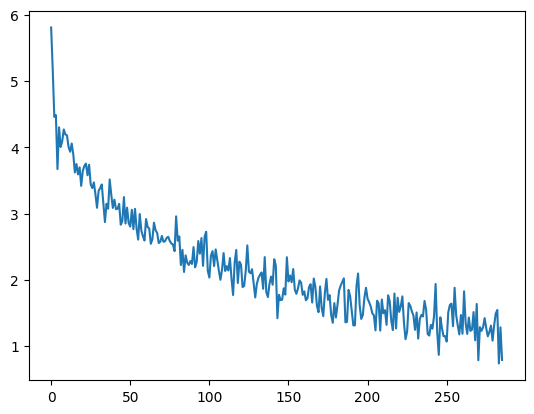

In [17]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(lossi[: len(lossi) // 6 * 6]).view(-1, 6).mean(dim=-1))
plt.show()